In [1]:
! git clone https://github.com/soerenab/AudioMNIST

Cloning into 'AudioMNIST'...
remote: Enumerating objects: 30122, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 30122 (delta 0), reused 0 (delta 0), pack-reused 30119
Receiving objects: 100% (30122/30122), 944.54 MiB | 17.47 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Checking out files: 100% (30018/30018), done.


In [4]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np
import shutil

from typing import List, Tuple
from glob import glob

import os
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, Audio
%matplotlib inline

DIGIT_NAMES = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [6]:
x, sr = torchaudio.load('/content/AudioMNIST/data/08/0_08_10.wav')
x = x[0].numpy()

print(", ".join(DIGIT_NAMES))
display(Audio(x, rate=sr))


zero, one, two, three, four, five, six, seven, eight, nine


In [7]:
def plot_signal_energies(x, sr, energies_db, intervals=None):
    fig = plt.figure(figsize=(len(x) / sr, 2.5))
    plt.plot(x, color='#20639b', label='audio signal')
    plt.xticks(np.arange(0, len(x), sr), np.int32(np.arange(0, len(x), sr) / sr))
    plt.grid(alpha=0.5, linestyle='--')
    plt.xlabel('time [s]')
    plt.ylabel('amplitude')
    plt.ylim([-0.51, 0.51])
    plt.xlim(-50, len(x) + 50)
    if intervals:
        for a, b in intervals:            
            plt.gca().add_patch(patches.Rectangle(
                (a, -0.51), (b - a), 1.2, 
                linewidth=1, edgecolor='none', 
                facecolor='#3caea3', alpha=0.3))

    plt.twinx()
    plt.plot(
        np.linspace(0, len(x), len(energies_db)), energies_db, 
        color='#3caea3', label='energy (window size = 512)')
    plt.ylabel('Energy [dB]')
    plt.legend(loc='best')
    plt.show()


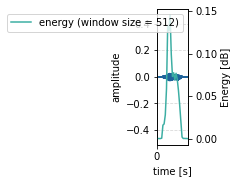

In [8]:
win_size = 1024

x, sr = torchaudio.load('/content/AudioMNIST/data/08/0_08_10.wav')
x = x[0].numpy()

energies_db = []
for i in range(len(x) // win_size + 1):
    x_win = x[i * win_size: (i + 1) * win_size]
    energies_db.append(sum(np.array(x_win) ** 2))    

energies_db = np.array(energies_db)

plot_signal_energies(x, sr, energies_db)


In [10]:
from torch.utils.data import Dataset

class AudioMNISTDataset(Dataset):
    def __init__(self,directory: str, mode: str):
        self.mode = mode
        self.filepaths = []
        self.labels = []

        for filepath in sorted(glob(os.path.join(directory, '*', '?_*_*.wav'))):
            digit, speaker, example_id = os.path.basename(filepath).replace('.wav', '').split('_')
            add = False
            if speaker == 'test' and mode == 'test':
                add = True
            if speaker != 'test' and int(speaker) % 6 == 0 and mode == 'valid':
                add = True
            if speaker != 'test' and int(speaker) % 6 != 0 and mode == 'train':
                add = True
            if add:
                self.filepaths.append(filepath)
                self.labels.append(int(digit))
    def __getitem__(self, idx: int):
        x, sr = torchaudio.load(self.filepaths[idx])
        y = torch.LongTensor([self.labels[idx]])[0]
        effects = [
            ['gain', '-n', '0'],    
            ['remix', '-'],            
            ['rate', '16000']
        ]
        x, sr = torchaudio.sox_effects.apply_effects_tensor(x, sr, effects)

        return (x[0].unsqueeze(0).to(device), y.unsqueeze(0).to(device))

    def __len__(self):
        return len(self.filepaths)

train_dataset = AudioMNISTDataset('AudioMNIST/data', mode='train')
valid_dataset = AudioMNISTDataset('AudioMNIST/data', mode='valid')
test_dataset = AudioMNISTDataset('AudioMNIST/data', mode='test')



In [11]:
len(test_dataset)

0

In [12]:
train_dataset[1][0].shape

torch.Size([1, 10452])

In [38]:
import torchvision.transforms

dataset_transforms = nn.Sequential(
    torchaudio.transforms.MFCC(sample_rate=sr, n_mfcc=128)
).to(device)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


visualize dataset for training


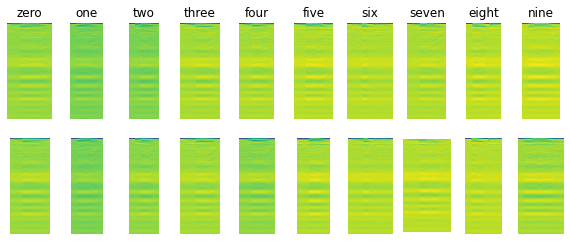

visualize dataset for validation


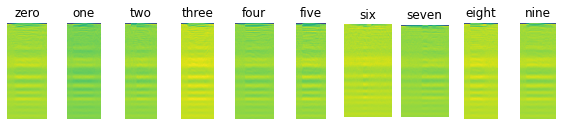

In [39]:
def show_some_examples(dataset, K, figsize=(10, 6)):
    fig = plt.figure(figsize=figsize)
    for digit in range(10):
        indices = np.where(np.array(dataset.labels) == digit)[0]
        for i in range(K):
            x, y = dataset[indices[i]]
            x = dataset_transforms(x)
            ax = fig.add_subplot(3, 10, digit + i * 10 + 1)
            #rotate
            if i == 0:
                ax.set_title(DIGIT_NAMES[digit])
            ax.imshow(x.cpu().squeeze(0))
            ax.axis('off')
    plt.show()

print("visualize dataset for training")
show_some_examples(train_dataset, 2)

print("visualize dataset for validation")
show_some_examples(valid_dataset, 1)


In [40]:
dataset_transforms(train_dataset[100][0]).shape

torch.Size([1, 128, 39])

### Conv1D

In [41]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        #(batch_size, 128, 128)
        self.model = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Flatten(),
            nn.Linear(16 * 16, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 10),
            nn.Softmax()
        )

    def forward(self, X):
        return self.model(X)

In [42]:
def transform_input_tensor(batch: torch.Tensor):
    transformed = dataset_transforms(batch)
    transformed = F.pad(transformed, (0, 128 - transformed.shape[2]),  "constant", -1)
    return transformed

In [43]:
model = Classifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

In [44]:
@torch.no_grad()
def inference_score(model):
    sum_strikes = 0
    cnt_samples = 0
    for batch in valid_dataset:
        output = model(transform_input_tensor(batch[0]))
        predicted_values = torch.argmax(output, dim=1).cpu().detach().numpy()
        correct_values = batch[1].cpu().detach().numpy()

        sum_strikes += sum(predicted_values == correct_values)
        cnt_samples += len(correct_values)

    return sum_strikes / cnt_samples

In [45]:
from tqdm.auto import tqdm

num_epochs = 5

for epoch in tqdm(range(num_epochs)):
    model.train()
    sum_loss, cnt_loss = 0, 0
    for i, batch in tqdm(enumerate(train_dataset)):
        optimizer.zero_grad()
        transformed_batch = transform_input_tensor(batch[0])
        output = model(transformed_batch)
        loss = criterion(output, batch[1])
        sum_loss += loss.item()
        cnt_loss += 1
        loss.backward()
        optimizer.step()
    model.eval()
    print(f"Mean loss per epoch is {sum_loss / cnt_loss}")
    print(f"ACCURACY : {inference_score(model)}")

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Mean loss per epoch is 2.015257019867897
ACCURACY : 0.5048


0it [00:00, ?it/s]

Mean loss per epoch is 1.7386335792541503
ACCURACY : 0.3832


0it [00:00, ?it/s]

Mean loss per epoch is 1.6154817677736282
ACCURACY : 0.5212


0it [00:00, ?it/s]

Mean loss per epoch is 1.5211530954933166
ACCURACY : 0.4144


0it [00:00, ?it/s]

Mean loss per epoch is 1.4865525554990768
ACCURACY : 0.416


### Conv2d

In [61]:
class Classifier2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Flatten(),
            nn.Linear(16 * 4 * 4, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 10),
            nn.Softmax()
        )
    def forward(self, X):
        return self.model(X)

In [62]:
model = Classifier2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

In [66]:
@torch.no_grad()
def inference_score(model):
    sum_strikes = 0
    cnt_samples = 0
    for batch in valid_dataset:
        output = model(transform_input_tensor(batch[0]).unsqueeze(0))
        predicted_values = torch.argmax(output, dim=1).cpu().detach().numpy()
        correct_values = batch[1].cpu().detach().numpy()

        sum_strikes += sum(predicted_values == correct_values)
        cnt_samples += len(correct_values)

    return sum_strikes / cnt_samples

In [69]:
from tqdm.auto import tqdm

num_epochs = 15

for epoch in tqdm(range(num_epochs)):
    model.train()
    sum_loss, cnt_loss = 0, 0
    for batch in tqdm(train_dataset):
        optimizer.zero_grad()
        transformed_batch = transform_input_tensor(batch[0]).unsqueeze(0)
        output = model(transformed_batch)
        loss = criterion(output, batch[1])
        sum_loss += loss.item()
        cnt_loss += 1
        loss.backward()
        optimizer.step()
    model.eval()
    print(f"Mean loss per epoch is {sum_loss / cnt_loss}")
    print(f"ACCURACY : {inference_score(model)}")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Mean loss per epoch is 1.4742334415864944
ACCURACY : 0.8052


  0%|          | 0/25000 [00:00<?, ?it/s]

Mean loss per epoch is 1.472380439143181
ACCURACY : 0.8588


  0%|          | 0/25000 [00:00<?, ?it/s]

Mean loss per epoch is 1.4730755818748473
ACCURACY : 0.8742


  0%|          | 0/25000 [00:00<?, ?it/s]

Mean loss per epoch is 1.471178335380554
ACCURACY : 0.8198


  0%|          | 0/25000 [00:00<?, ?it/s]

Mean loss per epoch is 1.4685575433015823
ACCURACY : 0.8238


### Best score - 0.8742
